# MNIST Dataset #

Famoso conjunto de imagens de dígidos manuscritos, dividido em $60000$ imagens de treinamento e $10000$ imagens de teste. Todas as imagens são em escala de cinza com tamanho $28 \times 28$. Existem 10 classes, correspondentes aos dígitos de 0 a 9.

Este dataset está disponível em diversos lugares. Abaixo, vamos usar a versão disponível na biblioteca Keras [1]. Informações adicionais estão disponíveis no [site oficial](http://yann.lecun.com/exdb/mnist/).

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Using TensorFlow backend.


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Vamos visualizar algumas das imagens

label: 5
label: 0
label: 4
label: 1
label: 9
label: 2


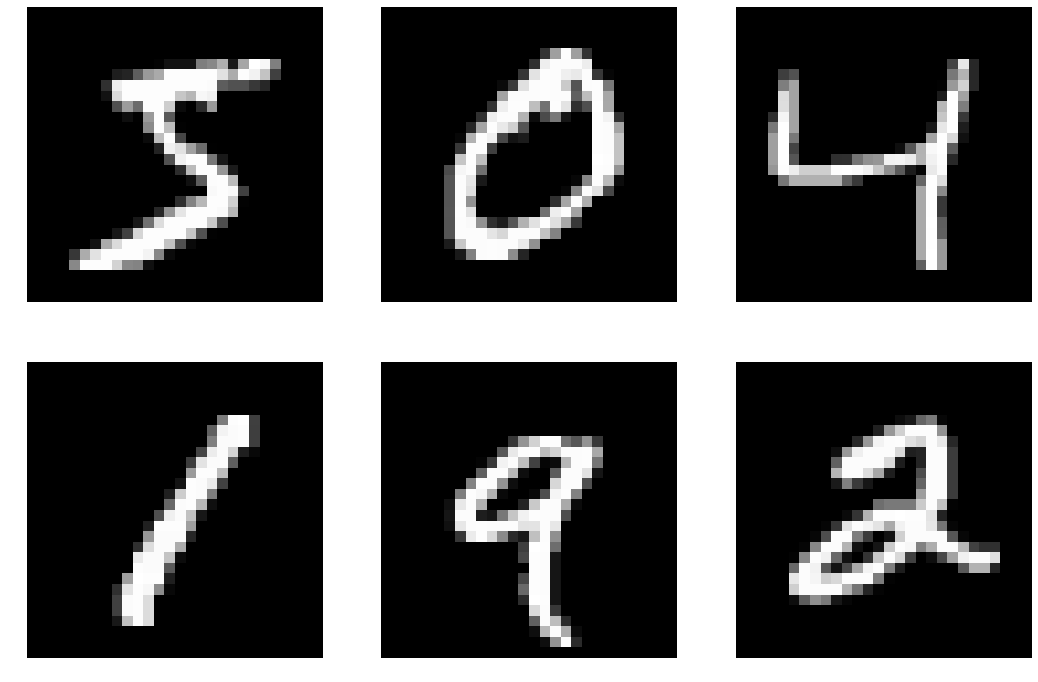

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 3, figsize = (18, 12))

for i in range(6):
    ax[i//3, i%3].imshow(x_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    print('label:', y_train[i])
    
plt.show()

# Extração de Features #

Por enquanto, não iremos aplicar nenhuma técnica de aprendizado diretamente sobre as imagens (pixels). Vamos utilizar alguns atributos que iremos extrair a seguir.

### Simetria ###

No livro _Learning from Data_ [2], um dos atributos que os autores extraem como exemplo do MNIST é a Simetria horizontal.

Seja a assimetria definida como a diferença absoluta média entre os pixels da imagem original e da imagem refletida horizontalmente, a simetria é simplesmente o inverso da assimetria.

In [3]:
import numpy as np

def simetry(image):
    # A operação abaixo inverte a ordem das colunas da imagem
    reflected_image = image[:, ::-1]
    return -np.mean(np.abs(image - reflected_image))

### Intensidade Média da Imagem ###

Outro atributo extraído como exemplo no livro _Learning from Data_ é a intensidade média dos pixels. Este atributo está associado a proporção da imagem ocupada pelo dígito. Por exemplo, a intensidade de uma imagem com o dígito $1$ é menor do que a de uma imagem com o dígito $2$ out $5$.

In [4]:
import numpy as np

def average_intensity(image):
    return np.mean(image)

## Pixels $\rightarrow$ Features ##

Agora, aplicamos as funções descritas anteriormente sobre as imagens do MNIST. Note que, na forma de imagens, os dados eram representados por $28 \times 28 = 784$ atributos, enquanto que agora, eles são representados por apenas $2$ atributos.

É de se esperar que um certo grau de informação se perca neste mapeamento. Em situações reais, escolhemos as features a serem extraídas de modo a preservar o máximo possível de informações úteis.

In [5]:
import numpy as np

# A função abaixo converte uma imagem em uma lista de atributos,
# usando as funções definidas acima
def convert2features(image):
    return np.array([average_intensity(image), simetry(image)])

# Aplica a conversão a todas as entradas do dataset
x_train_features = np.array([convert2features(image) for image in x_train])
x_test_features  = np.array([convert2features(image) for image in x_test])

# Ajusta a escala das features. Utilizar multiplas features com escalas diferentes pode ser problemático
for i in range(x_train_features.shape[1]):
    avg = np.mean(x_train_features[:, i])
    stddev = np.std(x_train_features[:, i])
    x_train_features[:, i] = (x_train_features[:, i] - avg) / stddev
    # (Sim, as features no conjunto de teste são ajustadas usando as estatísticas do conjunto de treinamento)
    x_test_features[:, i] = (x_test_features[:, i] - avg) / stddev

print(x_train_features.shape)
print(x_test_features.shape)

(60000, 2)
(10000, 2)


# Algoritmos #

Da mesma forma que o exemplo do livro, vamos nos concentrar em identificar apenas os dígitos $1$ e $5$. Vamos juntar os dados com labels 1 e 5, e embaralhar a ordem.

In [6]:
# Antes de mais nada, definir a seed aleatória como uma constante,
# de forma que todos os experimentos obtenham o mesmo resultado
np.random.seed(56789)

x_train_1 = x_train_features[y_train == 1]
x_train_5 = x_train_features[y_train == 5]
y_train_1 = y_train[y_train == 1]
y_train_5 = y_train[y_train == 5]

x_test_1 = x_test_features[y_test == 1]
x_test_5 = x_test_features[y_test == 5]
y_test_1 = y_test[y_test == 1]
y_test_5 = y_test[y_test == 5]

x_train_features_1_5 = np.concatenate([x_train_1, x_train_5], axis = 0)
y_train_1_5 = np.concatenate([y_train_1, y_train_5], axis = 0).astype('float32')

x_test_features_1_5 = np.concatenate([x_test_1, x_test_5], axis = 0)
y_test_1_5 = np.concatenate([y_test_1, y_test_5], axis = 0).astype('float32')

# Considere o digito 1 como a instancia negativa (-1) e o 5 como a positiva (+1)
y_train_1_5[y_train_1_5 == 1] = -1
y_train_1_5[y_train_1_5 == 5] = +1

y_test_1_5[y_test_1_5 == 1] = -1
y_test_1_5[y_test_1_5 == 5] = +1

def shuffle(X, y):
    # Com cuidado para embaralhar a entrada e a saída da mesma forma
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

x_train_features_1_5, y_train_1_5 = shuffle(x_train_features_1_5, y_train_1_5)

print(x_train_features_1_5.shape, y_train_1_5.shape)
print(x_test_features_1_5.shape, y_test_1_5.shape)

(12163, 2) (12163,)
(2027, 2) (2027,)


Em seguida, vamos plotar o conjunto de treinamento no plano cartesiano, onde os eixos correspondem aos atributos que acabamos de extrair.

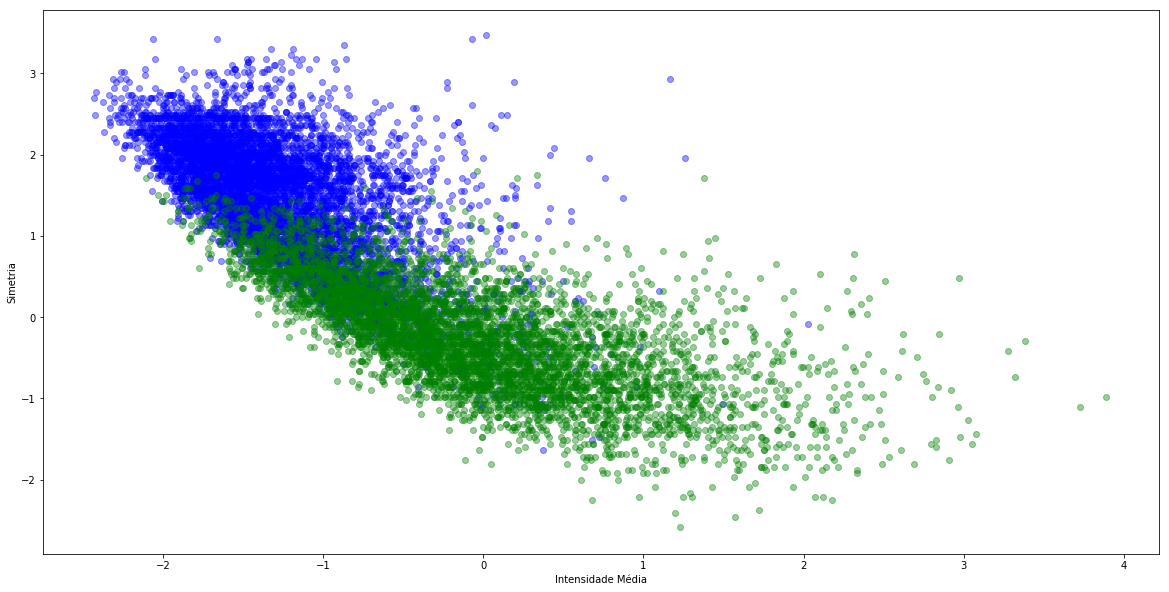

In [7]:
plt.figure(figsize=(20,10))

# Plotamos os 1s em azul...
plt.scatter(x = x_train_1[:,0], y = x_train_1[:,1], c = 'blue', alpha = 0.4)

# ...e os 5s em verde
plt.scatter(x = x_train_5[:,0], y = x_train_5[:,1], c = 'green', alpha = 0.4)

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

Como era de se esperar, os $1$s geralmente possuem menor intensidade maior simetria que os $5$s. Além disso, existe mais variação na forma como é possível desenhar os $5$s (note a dispersão dos pontos verdes).

É importante notar que existe uma sobreposição considerável de $1$s e $5$s, indicando a não separabilidade linear dos dados quando representado através destas features.

## Perceptron ##

O primeiro algoritmo avaliado será a versão básica do Perceptron. Iremos rodar o PLA por 1000 iterações, sempre escolhendo o primeiro exemplo erroneamente classificado do dataset.

[0.04324016 0.90881283 0.06403064]
[ 0.04324016  0.85139757 -2.55085472]


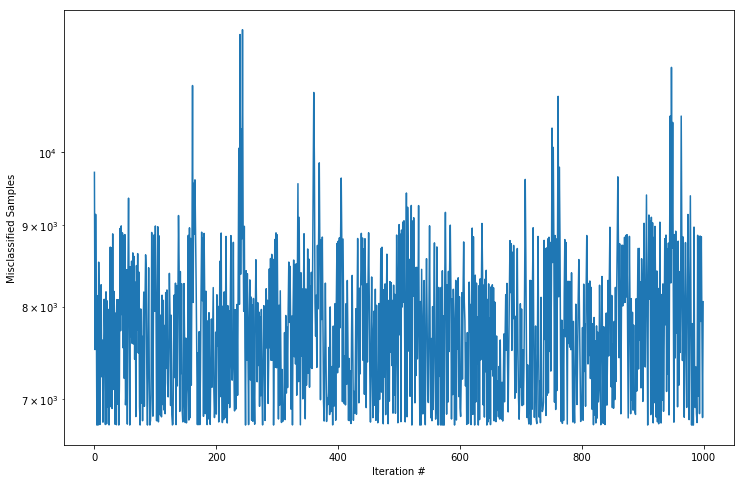

In [8]:
def update(w, x, y, i):
    '''
    Updates weight vector w
    '''
    return w + np.multiply(y[i], x[i])

def sign(x):
    return np.array(x > 0)

def E_in(w, X, y):
    return np.mean(np.sum(sign(X.dot(w)) != y))

# Retorna a saida do perceptron definido pelo vetor de pesos w (shape = (d,))
# aplicado aos exemplos na matriz X (shape = (N, d))
def predict(X, w):
    # Make sure the data matrix has a bias coordinate
    if X.shape[1] != w.shape[0]:
        # Add a bias value 1 as the first coordinate of each vector
        X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)
    return np.sign(np.dot(X, w))

# A função a seguir recebe a matriz de dados X (shape = (N, d)) e vetor de saída
# y (shape = (N,)), e retorna um vetor de pesos de acordo com o PLA
# e, caso return_history = True, uma lista com a quantidade de erros cometidos a cada iteração
def PLA(X, y, w0 = None, max_iterations = 1000, return_history = False):
    iterations = max_iterations
    n = len(X)
    X = np.insert(X, 0, 1, axis=1)
    w0 = np.random.rand(1,len(X[0])) if w0 == None else w0
    # selecting lines
    w0 = w0[0]
    print(w0)
    errors = [0 for i in range(iterations)]
    
    it = 0
    while it < iterations:
        for i in range(n):
            h_x = float(w0.dot(X[i]))
            sign = np.sign(h_x) == y[i]
            if not sign:
                errors[it] = E_in(w0, X, y)
                it += 1
                w0 = update(w0, X, y, i)
            if it >= iterations:
                break

    if return_history:
        return w0, errors
    return w0


np.random.seed(1257)
w_pla, errors = PLA(x_train_features_1_5, y_train_1_5, return_history = True)

print(w_pla)

plt.figure(figsize = (12, 8))
plt.plot(errors)
plt.yscale('log')
plt.xlabel('Iteration #')
plt.ylabel('Misclassified Samples')
plt.show()

Observe que a quantidade de erros oscila significativamente ao longo das iterações. Isto se deve a natureza local das atualizações realizadas pelo PLA. Ao corrigir a classificação de um ponto, outros pontos (possivelmente vários) corretos podem passar para o lado errado da fronteira de classificação.

Vamos visualizar a fronteira de classificação obtida junto com os dados.

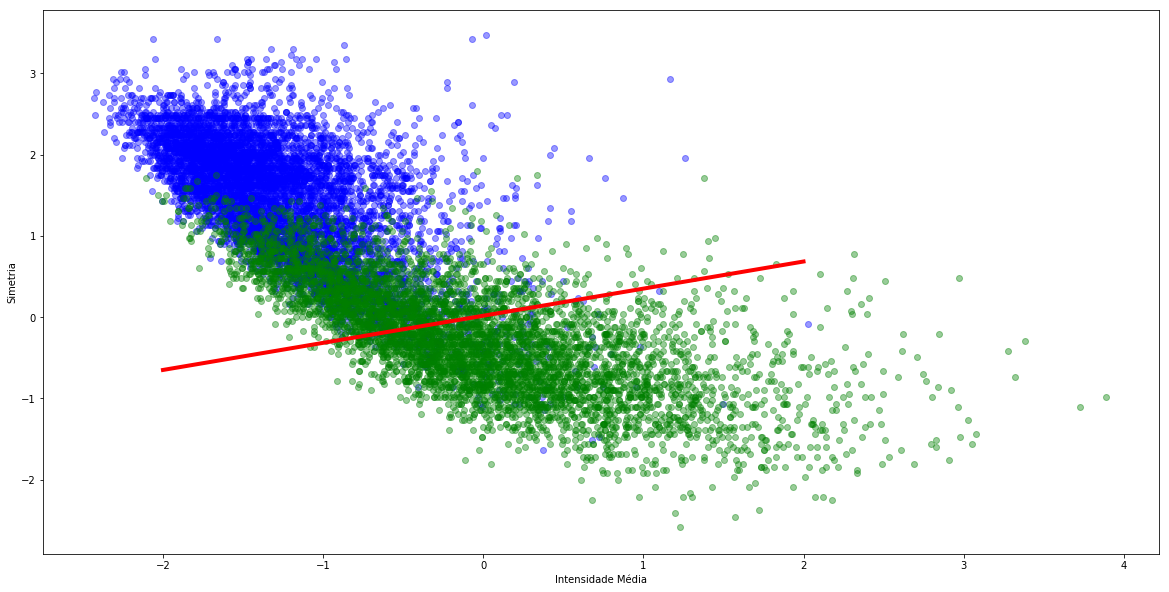

In [9]:
plt.figure(figsize=(20,10))

# Plotamos os 1s em azul...
plt.scatter(x = x_train_1[:,0], y = x_train_1[:,1], c = 'blue', alpha = 0.4)

# ...e os 5s em verde
plt.scatter(x = x_train_5[:,0], y = x_train_5[:,1], c = 'green', alpha = 0.4)

# A fronteira é uma linha no formato w_pla[0] + w_pla[1]*intensidade + w_pla[2]*simetria = 0
# Obter dois pontos quaisquer na fronteira

p1 = (-2, -(w_pla[0] - 2*w_pla[1])/w_pla[2])
p2 = (2,  -(w_pla[0] + 2*w_pla[1])/w_pla[2])

lines = plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='r', linewidth=4.0)

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

### Matriz de confusão ###


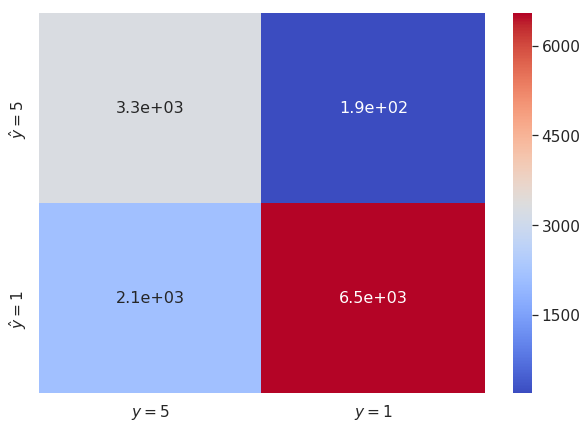

In [10]:
import seaborn as sn
import pandas as pd

y_true = y_train_1_5
y_pred = predict(x_train_features_1_5, w_pla)

true_positives = np.sum((y_pred == +1) * (y_true == +1))
true_negatives = np.sum((y_pred == -1) * (y_true == -1))

false_positives = np.sum((y_pred == +1) * (y_true == -1))
false_negatives = np.sum((y_pred == -1) * (y_true == +1))

confusion = [
    [true_positives, false_positives],
    [false_negatives, true_negatives]
]

df_cm = pd.DataFrame(confusion, ['$\hat{y} = 5$', '$\hat{y} = 1$'], ['$y = 5$', '$y = 1$'])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'coolwarm')

Como já era de se esperar pela fronteira de classificação, os $1$s foram classificados mais facilmente do que os $5$s.

## Pocket ##

Desta vez, vamos usar a versão pocket do Perceptron.

[ 0.16287191  0.450626   -1.65319722]


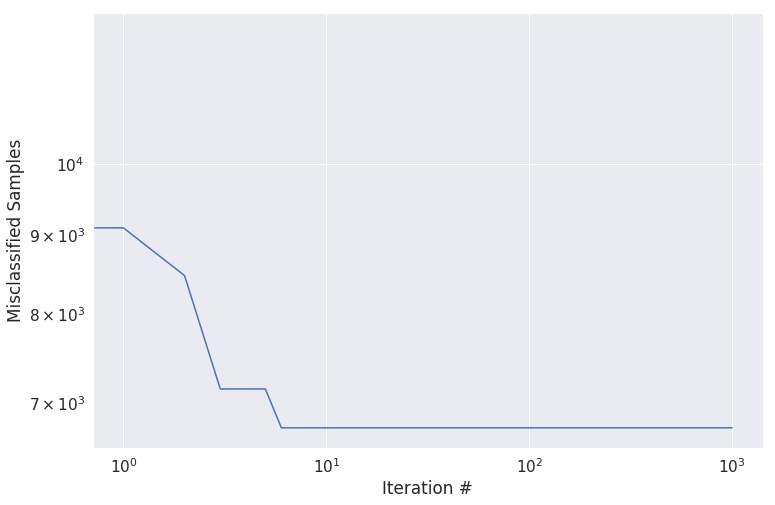

In [11]:
# A função a seguir recebe a matriz de dados X (shape = (N, d)) e vetor de saída
# y (shape = (N,)), e retorna um vetor de pesos de acordo com o Pocket Perceptron
# e, caso return_history = True, uma lista com a quantidade de erros cometidos a cada iteração
def PLA_pocket(X, y, w0 = None, max_iterations = 1000, return_history = False):
    iterations = max_iterations
    n = len(X)
    X = np.insert(X, 0, 1, axis=1)
    w0 = 3*np.random.rand(1,len(X[0]))-1 if w0 == None else w0
    # selecting lines
    w0 = w0[0]
    errors = [0 for i in range(iterations)]
    
    errors[0] = n
    it = 1
    while it < iterations:
        for i in range(n):
            h_x = float(w0.dot(X[i]))
            sign = np.sign(h_x) == y[i]
            if not sign:
                w0 = update(w0, X, y, i)
                e_in_w0 = E_in(w0, X, y)
                if e_in_w0 < errors[it-1]:
                    errors[it] = e_in_w0
                else:
                    errors[it] = errors[it-1]
                it += 1
            if it >= iterations:
                break
    
    if return_history:
        return w0, errors
    return w0

np.random.seed(18375)
w_pocket, errors = PLA_pocket(x_train_features_1_5, y_train_1_5, return_history = True)

print(w_pocket)

plt.figure(figsize = (12, 8))
plt.plot(errors)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration #')
plt.ylabel('Misclassified Samples')
plt.show()

Como era esperado, a quantidade de erros associados ao vetor de pesos que está "no pocket" jamais aumenta.

Vamos visualizar a nova fronteira de classificação.

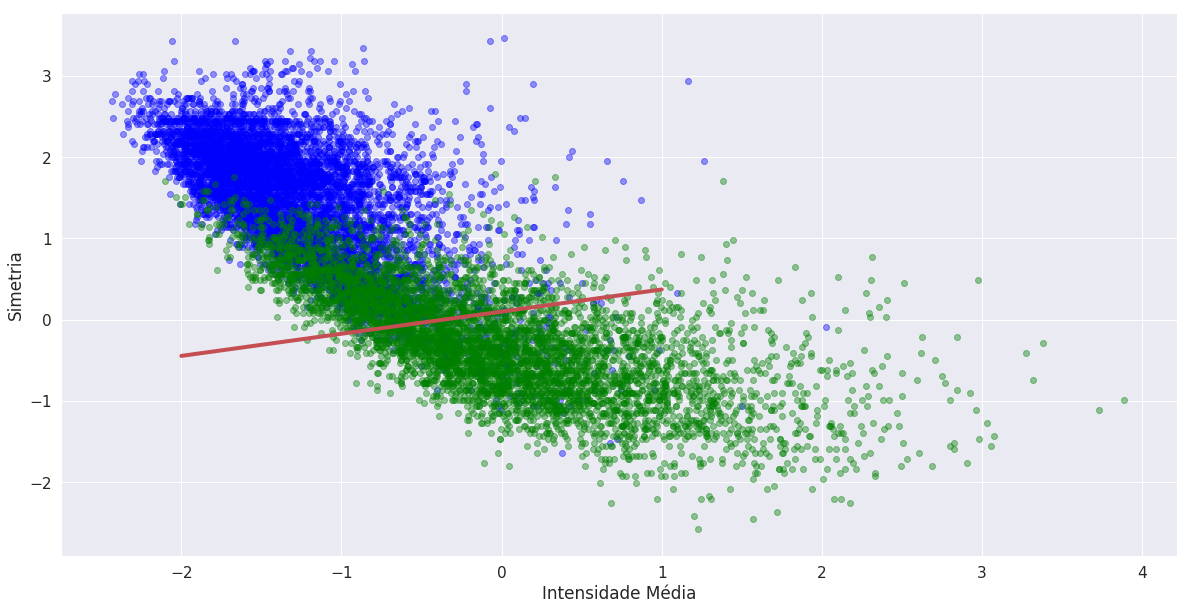

In [12]:
plt.figure(figsize=(20,10))

# Plotamos os 1s em azul...
plt.scatter(x = x_train_1[:,0], y = x_train_1[:,1], c = 'blue', alpha = 0.4)

# ...e os 5s em verde
plt.scatter(x = x_train_5[:,0], y = x_train_5[:,1], c = 'green', alpha = 0.4)

# A fronteira é uma linha no formato w_pla[0] + w_pla[1]*intensidade + w_pla[2]*simetria = 0
# Obter dois pontos quaisquer na fronteira

p1 = (-2, -(w_pocket[0] - 2*w_pocket[1])/w_pocket[2])
p2 = (1,  -(w_pocket[0] + 1*w_pocket[1])/w_pocket[2])

lines = plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='r', linewidth=4.0)

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

### Matriz de confusão ###

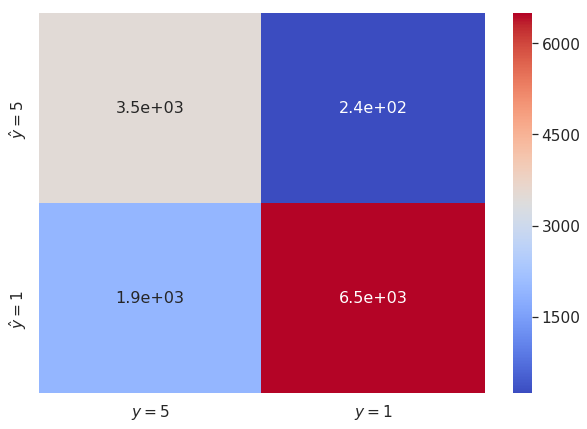

In [13]:
import seaborn as sn
import pandas as pd

y_true = y_train_1_5
y_pred = predict(x_train_features_1_5, w_pocket)

true_positives = np.sum((y_pred == +1) * (y_true == +1))
true_negatives = np.sum((y_pred == -1) * (y_true == -1))

false_positives = np.sum((y_pred == +1) * (y_true == -1))
false_negatives = np.sum((y_pred == -1) * (y_true == +1))

confusion = [
    [true_positives, false_positives],
    [false_negatives, true_negatives]
]

df_cm = pd.DataFrame(confusion, ['$\hat{y} = 5$', '$\hat{y} = 1$'], ['$y = 5$', '$y = 1$'])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'coolwarm')

## Sinal da Regressão Linear ##

Desta vez, vamos usar o sinal da regressão linear para classificar os exemplos. 

Queremos minimizar o erro quadrado médio:

$$E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N (\mathbf{w}^T \mathbf{x}_n - y_n)^2$$

Para o qual existe uma fórmula fechada (demonstração no livro _Learning from Data_ [2]):

$$\mathbf{w}_{lin} = \text{X}^{\dagger} y$$

onde

$$\text{X}^{\dagger} = (\text{X}^T \text{X})^{-1} \text{X}^T$$

In [14]:
# A função a seguir recebe a matriz de dados X (shape = (N, d)) e vetor de saída
# y (shape = (N,)), e retorna o (único) vetor de pesos que minimiza o erro quadrado médio.
def linear_regression(X, y):
    X = np.insert(X, 0, 1, axis=1)
    return np.linalg.inv(X.T @ X) @ (X.T @ y)

    
w_lin = linear_regression(x_train_features_1_5, y_train_1_5)

print(w_lin)

[ 0.39811184  0.13328504 -0.59080261]


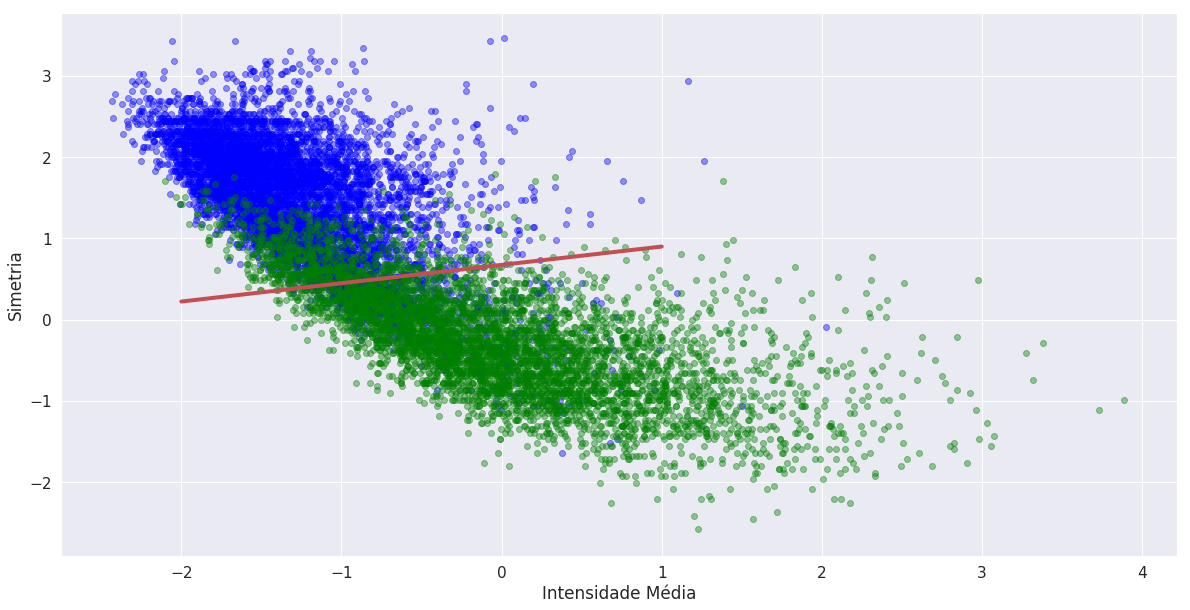

In [15]:
plt.figure(figsize=(20,10))

# Plotamos os 1s em azul...
plt.scatter(x = x_train_1[:,0], y = x_train_1[:,1], c = 'blue', alpha = 0.4)

# ...e os 5s em verde
plt.scatter(x = x_train_5[:,0], y = x_train_5[:,1], c = 'green', alpha = 0.4)

# A fronteira é uma linha no formato w_lin[0] + w_lin[1]*intensidade + w_lin[2]*simetria = 0
# Obter dois pontos quaisquer na fronteira

p1 = (-2, -(w_lin[0] - 2*w_lin[1])/w_lin[2])
p2 = (1,  -(w_lin[0] + 1*w_lin[1])/w_lin[2])

lines = plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='r', linewidth=4.0)

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

É possível perceber que a fronteira obtida com a regressão linear faz sentido em relação as classes.

### Matriz de confusão ###

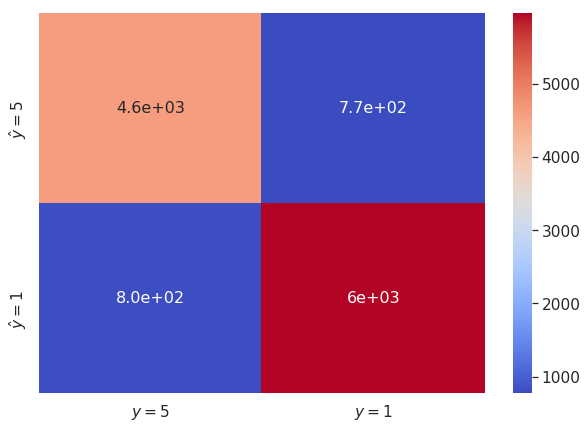

In [16]:
import seaborn as sn
import pandas as pd

y_true = y_train_1_5
y_pred = predict(x_train_features_1_5, w_lin)

true_positives = np.sum((y_pred == +1) * (y_true == +1))
true_negatives = np.sum((y_pred == -1) * (y_true == -1))

false_positives = np.sum((y_pred == +1) * (y_true == -1))
false_negatives = np.sum((y_pred == -1) * (y_true == +1))

confusion = [
    [true_positives, false_positives],
    [false_negatives, true_negatives]
]

df_cm = pd.DataFrame(confusion, ['$\hat{y} = 5$', '$\hat{y} = 1$'], ['$y = 5$', '$y = 1$'])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'coolwarm')

## Regressão Logística ##

Neste próximo exercício, vamos tentar aplicar regressão logística. Antes de mais nada, vamos implementar a função de predição, que faz uso da função sigmoid, definida abaixo:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Retorna a saida da regressão logística definida pelo vetor de pesos w (shape = (d,))
# aplicado aos exemplos na matriz X (shape = (N, d))
def predict_logistic(X, w):
    # Make sure the data matrix has a bias coordinate
    if X.shape[1] != w.shape[0]:
        # Add a bias value 1 as the first coordinate of each vector
        X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)
    return sigmoid(np.dot(X, w))

Vamos implementar nossa função de custo. No nosso caso, entropia cruzada.

$$E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^{N} \ln(1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n})$$

E o seu gradiente, com relação aos pesos. Sabemos que o gradiente de $E_{in}$ é da seguinte forma:

$$\nabla E_{in}(\mathbf{w}) = - \frac{1}{N}\sum_{n=1}^{N} \frac{y_n \mathbf{x}_n}{1 + e^{y_n \mathbf{w}^T \mathbf{x}_n}}$$

As funções a seguir utilizam várias operações vetoriais em numpy.

In [18]:
def cross_entropy(w, X, y):
    return np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))

def cross_entropy_gradient(w, X, y):
    N = X.shape[0]
    return -np.dot(X.transpose(), y / (1 + np.exp(y * np.dot(X, w)))) / N

Por fim, o treinamento do modelo de regressão logística, usando _gradient descent_.

[ 1.00402016  1.11351416 -1.03501611]


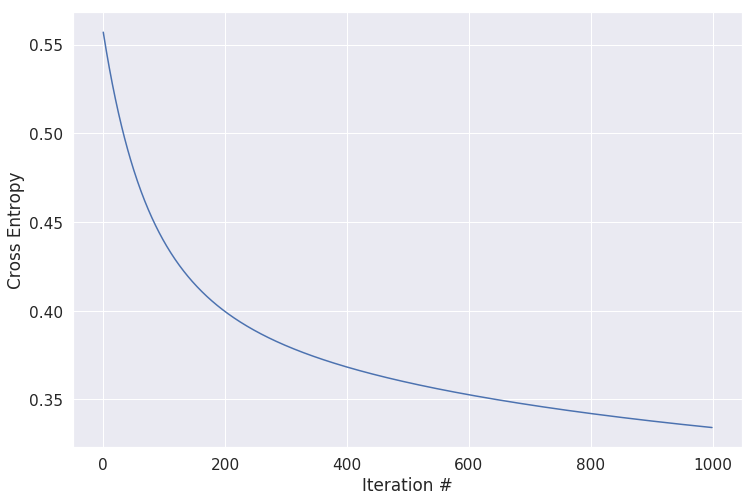

In [19]:
def group(l, size):
     for i in range(0, len(l), size):
             yield l[i:i+size]

# A função a seguir recebe a matriz de dados X (shape = (N, d)) e vetor de saída
# y (shape = (N,)), e retorna um vetor de pesos de acordo com o treinamento da regressão logística
# e, caso return_history = True, uma lista com o valor de cross_entropy a cada iteração
def logistic_regression(X, y, batch_size = None, learning_rate = 1e-2, w0 = None, num_iterations = 1000, return_history = False):
    X = np.insert(X, 0, 1, axis=1)
    w0 = np.random.rand(1, len(X[0])) if w0 == None else w0
    batch_size = len(X) if not batch_size else batch_size
    w0 = w0[0]
    errors = [0 for i in range(num_iterations)]
    batches = group(X, batch_size)
    y_batches = group(y, batch_size)
    for batch_x, batch_y in zip(batches, y_batches):
        for step in range(num_iterations):
            gt = cross_entropy_gradient(w0, batch_x, batch_y)
            vt = -gt
            w0 = w0 + learning_rate * vt
            errors[step] = cross_entropy(w0, batch_x, batch_y)
    return w0, errors

np.random.seed(56789)
w_logistic, loss = logistic_regression(x_train_features_1_5, y_train_1_5, num_iterations = 1000, return_history = True)

print(w_logistic)

plt.figure(figsize = (12, 8))
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy')
plt.show()

Como é possível perceber pelo gráfico, o custo aparenta ter estagnado a partir de 10000 iterações. Como a regressão logística produz uma probabilidade, ao invés de visualizar a fronteira de classificação, vamos visualizar a intensidade da saída.

No gráfico abaixo, a intensidade de vermelho corresponde a probabilidade atribuída pela regressão logística para cada ponto. Quanto mais próximo de 1, maior é a confiança da regressão de que o ponto em questão seja um $5$. 

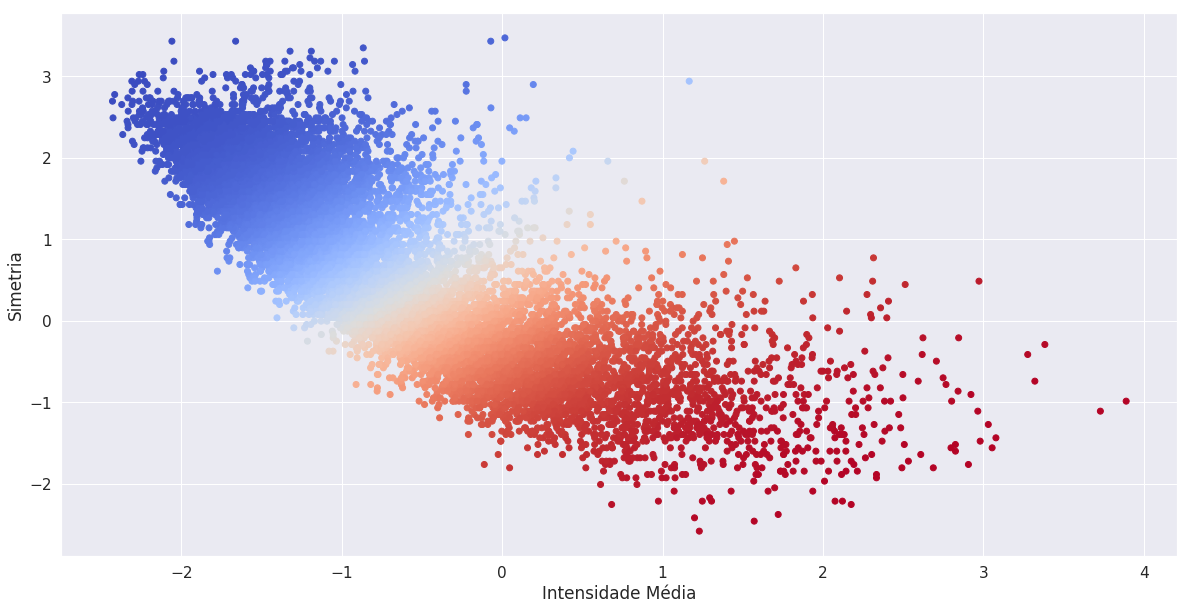

In [20]:
plt.figure(figsize=(20,10))

y_pred = predict_logistic(x_train_features_1_5, w_logistic)

plt.scatter(x = x_train_features_1_5[:,0], y = x_train_features_1_5[:,1], c = y_pred, cmap = 'coolwarm')

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

## Testando as previsões nos conjuntos de testes

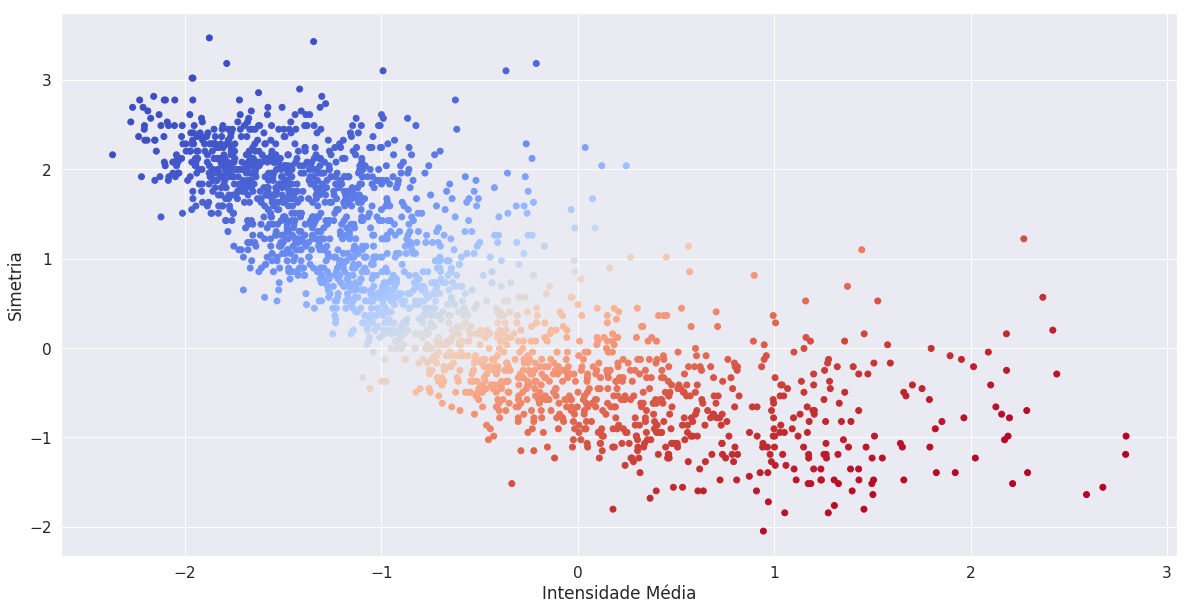

In [21]:
plt.figure(figsize=(20,10))

y_pred = predict_logistic(x_test_features_1_5, w_logistic)

plt.scatter(x = x_test_features_1_5[:,0], y = x_test_features_1_5[:,1], c = y_pred, cmap = 'coolwarm')

plt.xlabel('Intensidade Média')
plt.ylabel('Simetria')

plt.show()

Como é possível perceber, pontos nas extremidades do cluster possuem baixa probabilidade (azul escuro, maior confiança de ser um $1$), ou alta (vermelho escuro, maior confiança de ser um $5$), enquanto pontos na intersecção das duas classes possuem uma intensidade intermediária, associada com uma saída próxima de 0.5, idicando que a regressão não diferencia com confiança as classes nesta região.

### Matriz de confusão ###

Para atribuírmos categorias para a saída da regressão logística, precisamos definir um threshold entre 0 e 1, que diferencie as saídas positivas das negativas.

Em situações reais, este threshold deve ser definido de acordo com o custo associado a cada tipo de erro (falso positivo vs falso negativo, lembre-se do exemplo do supermercado e da CIA). Nesta situação, vamos manter o raciocínio simples e assumir um threshold de 0.5.

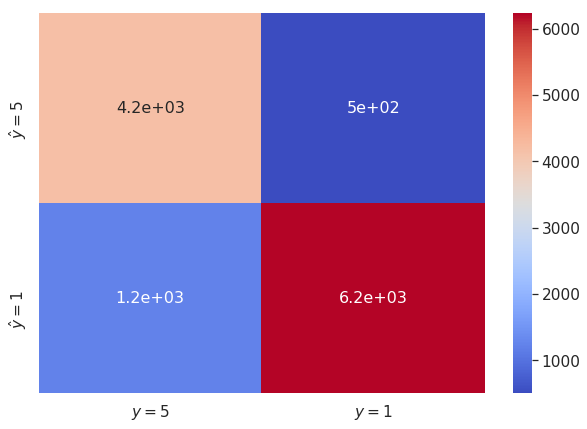

In [22]:
import seaborn as sn
import pandas as pd

threshold = 0.5

y_true = y_train_1_5
y_pred = predict_logistic(x_train_features_1_5, w_logistic) > threshold

true_positives = np.sum(y_pred * (y_true == +1))
true_negatives = np.sum((1-y_pred) * (y_true == -1))

false_positives = np.sum(y_pred * (y_true == -1))
false_negatives = np.sum((1-y_pred) * (y_true == +1))

confusion = [
    [true_positives, false_positives],
    [false_negatives, true_negatives]
]

df_cm = pd.DataFrame(confusion, ['$\hat{y} = 5$', '$\hat{y} = 1$'], ['$y = 5$', '$y = 1$'])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap = 'coolwarm')

[1]: François Chollet and others, Keras, https://keras.io, 2015

[2]: Yaser S Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin, _Learning from Data_, 2012

## Explorando os parâmetros da regressão logística

### Variando o tamanho do treinamento

Iremos variar o número de pontos usados no treinamento:

In [23]:
np.random.seed(56789)
logits = []
recall = []
precision = []
acc = []
e_test = []
x_train_size = len(x_train_features_1_5)
threshold = 0.5
y_true = y_test_1_5
steps = [i for i in range(0, x_train_size, 1000)]
steps.pop()
for i in range(1000, x_train_size, 1000):
    w_log, loss = logistic_regression(x_train_features_1_5[:i,:], y_train_1_5[:i], num_iterations = 1000, return_history = True)    
    y_pred = predict_logistic(x_test_features_1_5, w_log) > threshold
    
    true_positives = np.sum(y_pred * (y_true == +1))
    true_negatives = np.sum((1-y_pred) * (y_true == -1))

    false_positives = np.sum(y_pred * (y_true == -1))
    false_negatives = np.sum((1-y_pred) * (y_true == +1))
    
    logits.append((w_log, loss))
    e_test.append(cross_entropy(w_log, np.insert(x_test_features_1_5, 0, 1, axis=1), y_test_1_5))
    recall.append(true_positives / (false_negatives + true_positives))
    precision.append(true_positives / (true_positives + false_positives))
    acc.append((true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives))

### Recall x N

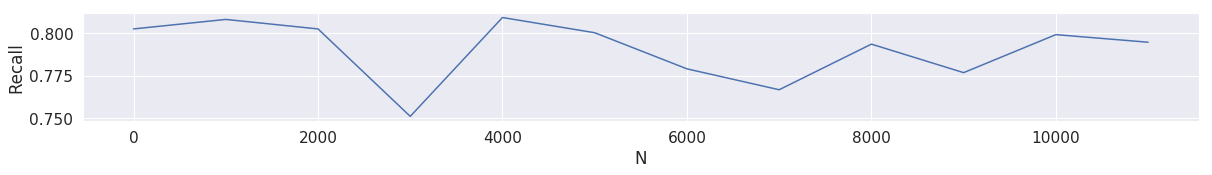

In [24]:
plt.figure(figsize = (20, 2))
plt.plot(steps, recall)
plt.xlabel('N')
plt.ylabel('Recall')
plt.show()

### Accuracy x N

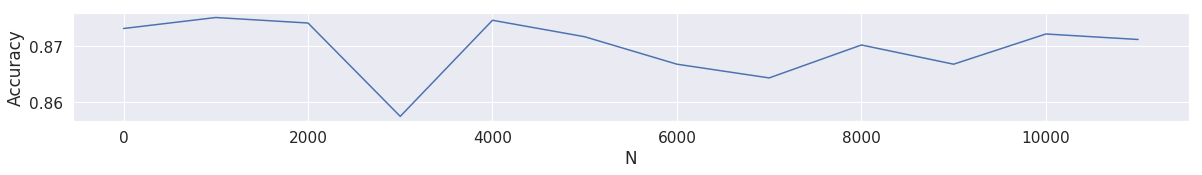

In [25]:
plt.figure(figsize = (20, 2))
plt.plot(steps, acc)
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.show()

### Precision x N

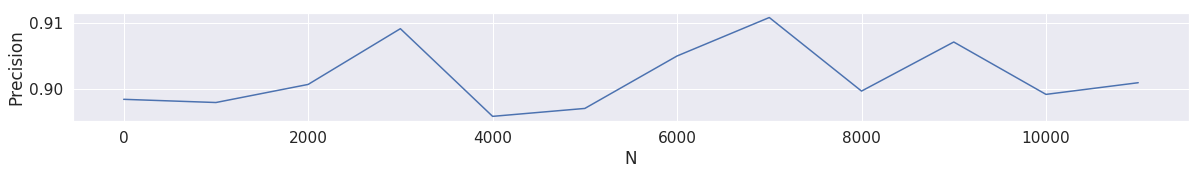

In [26]:
plt.figure(figsize = (20, 2))
plt.plot(steps, precision)
plt.xlabel('N')
plt.ylabel('Precision')
plt.show()

Podemos observar acurácia e recall variam de maneira parecida, apesar de diferirem de valor, enquanto a precisão varia com diferentes valores de N. As flutuações são pequenas, o que demonstram um bom funcionamento do algoritmo.

## Analisando as mudanças com o tamanho do batch

In [27]:
e_test_batch = []
acc_batch = []
batches = [i for i in range(500, x_train_size, 1000)]
for batch in batches:
    print('Tamanho do batch: ', batch)
    w_log, loss = logistic_regression(x_train_features_1_5, y_train_1_5, num_iterations=1000, return_history=True, batch_size=batch)
    y_pred = predict_logistic(x_test_features_1_5, w_log) > threshold
    
    true_positives = np.sum(y_pred * (y_true == +1))
    true_negatives = np.sum((1-y_pred) * (y_true == -1))
    false_positives = np.sum(y_pred * (y_true == -1))
    false_negatives = np.sum((1-y_pred) * (y_true == +1))
    
    e_test_batch.append(cross_entropy(w_log, np.insert(x_test_features_1_5, 0, 1, axis=1), y_test_1_5))
    acc_batch.append((true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives))

Tamanho do batch:  500
Tamanho do batch:  1500
Tamanho do batch:  2500
Tamanho do batch:  3500
Tamanho do batch:  4500
Tamanho do batch:  5500
Tamanho do batch:  6500
Tamanho do batch:  7500
Tamanho do batch:  8500
Tamanho do batch:  9500
Tamanho do batch:  10500
Tamanho do batch:  11500


### Accuracy x Batches

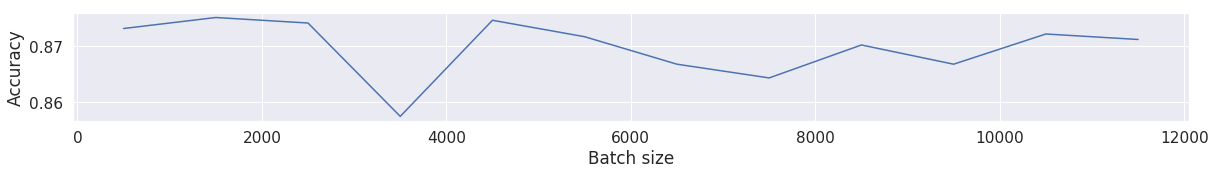

In [28]:
plt.figure(figsize = (20, 2))
plt.plot(batches, acc)
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.show()

### E_test x Batches

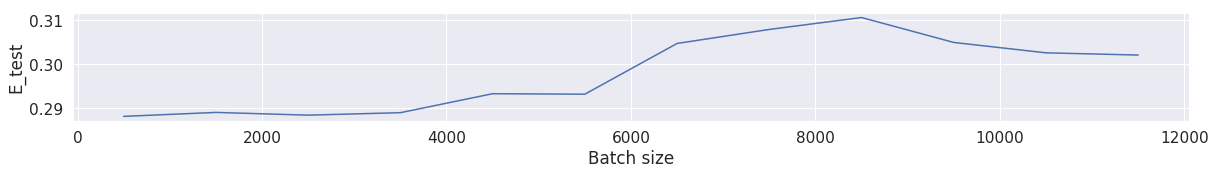

In [29]:
plt.figure(figsize = (20, 2))
plt.plot(batches, e_test_batch)
plt.xlabel('Batch size')
plt.ylabel('E_test')
plt.show()

Já nos batches, observamos uma queda na acurácia quando o tamanho do batch se aproxima de 4000. Mas novamente, as oscilações são entre valores pequenos, e portanto, demonstram que o algoritmo funciona bem para variados tamanhos de batch. O mesmo se aplica aos E_test's.

## Analisando as mudanças variando o learning rate

In [30]:
e_test_lr = []
acc_lr = []
lrs = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
for lr in lrs:
    print('Learning rate: ', lr)
    w_log, loss = logistic_regression(x_train_features_1_5, y_train_1_5, num_iterations=1000, return_history=True, learning_rate=lr)
    y_pred = predict_logistic(x_test_features_1_5, w_log) > threshold
    
    true_positives = np.sum(y_pred * (y_true == +1))
    true_negatives = np.sum((1-y_pred) * (y_true == -1))
    false_positives = np.sum(y_pred * (y_true == -1))
    false_negatives = np.sum((1-y_pred) * (y_true == +1))
    
    e_test_lr.append(cross_entropy(w_log, np.insert(x_test_features_1_5, 0, 1, axis=1), y_test_1_5))
    acc_lr.append((true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives))

Learning rate:  1e-10
Learning rate:  1e-09
Learning rate:  1e-08
Learning rate:  1e-07
Learning rate:  1e-06
Learning rate:  1e-05
Learning rate:  0.0001
Learning rate:  0.001
Learning rate:  0.01
Learning rate:  0.1
Learning rate:  1
Learning rate:  2


### Accuracy x Learning Rate

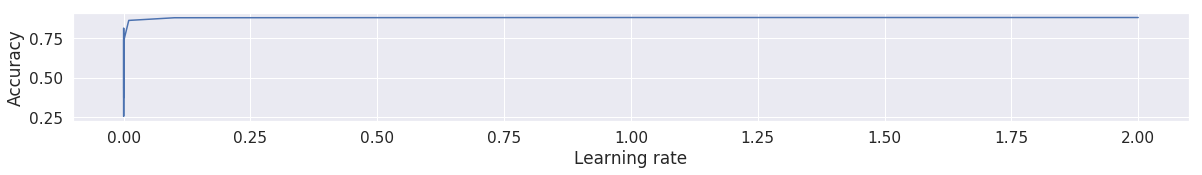

In [31]:
plt.figure(figsize = (20, 2))
plt.plot(lrs, acc_lr)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show()

### E_test x Learning Rate

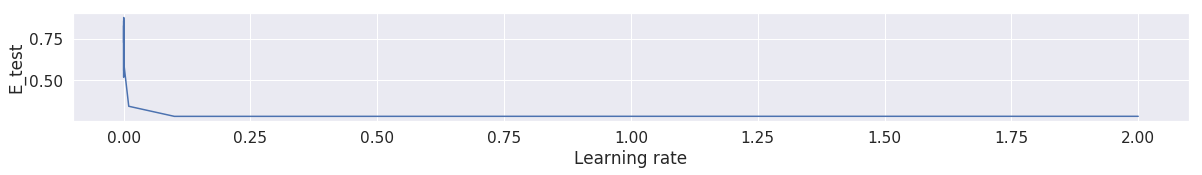

In [32]:
plt.figure(figsize = (20, 2))
plt.plot(lrs, e_test_lr)
plt.xlabel('Learning rate')
plt.ylabel('E_test')
plt.show()

In [33]:
e_test_lr

[0.558483210279973,
 0.5972044559122759,
 0.8282305414330353,
 0.5191236066728455,
 0.8572907950184319,
 0.7253494127514891,
 0.8762332570051561,
 0.583183644897385,
 0.34512940486740656,
 0.28472497951206927,
 0.2850380888230054,
 0.2850380965627305]